# IA353 - Redes Neurais
# EFC3 - Questão 7

## **Instalações dos pacotes:**


In [ ]:
!pip install innvestigate
!pip install scipy==1.1.0
!pip install git+https://github.com/raghakot/keras-vis.git -U

## **Imports**


In [2]:
%tensorflow_version 1.x  # utiliza a versão 1.x já presente no Colab

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import innvestigate
import keras

from vis.visualization import visualize_activation
from vis.utils import utils

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # utiliza a versão 1.x já presente no Colab`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


## **Leitura dos dados do MNIST:**


In [3]:
mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 2s 0us/step


## **Definição, treinamento e teste do modelo:**


In [4]:
# Definição:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

#####################################################################################################

# Treinamento
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

model.get_config()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=64)

#####################################################################################################

# Avaliação

evaluation = model.evaluate(x_test, y_test)

model.save('mnist_model.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





60000/60000 [==============================] - 20s 337us/step - loss: 0.2727 - acc: 0.9189
Epoch 2/5
60000/60000 [==============================] - 7s 118us/step - loss: 0.1105 - acc: 0.9661
Epoch 3/5
60000/60000 [==============================] - 8s 125us/step - loss: 0.0869 - acc: 0.9729
Epoch 4/5
60000/60000 [==============================] - 7s 119us/step - loss: 0.0729 - acc: 0.9775
Epoch 5/5
10000/10000 [==============================] - 1s 82us/step


## **Questão 7-A: Análise e comparação de diferentes métodos de explicação de uma RNA treinada com a biblioteca *innvestigate***


- **Considerações iniciais:**

  - Nesta atividade são analisadas 6 métodos de explicação da rede neural treinada, obtida anteriormente, considerando 6 imagens de 3 classes distintas (2 imagens por classe).

  - As imagens de dígitos manuscritos analisadas pertencem às classes 2, 7 e 8, e podem ser visualizadas na primeira coluna da figura no final desta seção.

  - Os métodos de explicação utilizados são:
    - Métodos baseados em função: *Gradient* e *SmoothGrad*.
    - Métodos baseados em atribuição: LRP-AlphaBeta, LRP-Epsilon, LRP-Z e *DeepTaylor*.

  - As escolhas dos valores dos parâmetros *alpha*, *beta* e *epsilon* nos métodos LRP-AlphaBeta e LRP-Epsilon foram feitas de modo a melhorar a explicação de ambos. Seguindo a literatura sugerida, os valores escolhidos foram:
    - *alpha* = 2 e *beta* = 1 (Satisfaz a condição *alpha* - *beta* = 1).
    - *epsilon* = 0.1 (Satisfaz a condição *epsilon* > 0). 

- **Função que retorna 2 imagens aleatórias para cada uma das 3 classes investigadas**

In [ ]:
def get_indices(classes, y_test):
    list_indices = []

    for CLASS in classes:
        # Retorna todos os índices cuja imagem pertence a classe desejada
        index = np.where(y_test == CLASS)[0] 

        # Pega 2 índices aleatórios
        np.random.shuffle(index)
        list_indices.append(index[0])
        list_indices.append(index[1])

    return list_indices

- **Instâncias de analyzers para cada um dos métodos de explicação:**

In [ ]:
model = keras.models.load_model('mnist_model.h5')
model_wo_sm = innvestigate.utils.model_wo_softmax(model)

methods = [('gradient', {}), 
           ('smoothgrad', {}), 
           ('deep_taylor', {}),
           ('lrp.alpha_beta', {'alpha': 2, 'beta': 1}),
           ('lrp.epsilon', {'epsilon': 0.1}),
           ('lrp.z', {})]

analyzers = [innvestigate.create_analyzer(method[0], model_wo_sm, **method[1]) for method in methods]

- **Aplicação dos métodos de explicação a cada uma das imagens investigadas:**

In [ ]:
indices = get_indices((2, 7, 8), y_test)
inputs_and_results = []

for index in indices:
    
    image = x_test[index:index+1]
    inputs_and_results.append(image.squeeze())

    
    for i in range(0, len(analyzers)):

        analyzer = analyzers[i]
        analysis = analyzer.analyze(image)
        inputs_and_results.append(analysis.squeeze())

- **Figura contendo as imagens de entrada investigadas e suas respectivas explicações:**

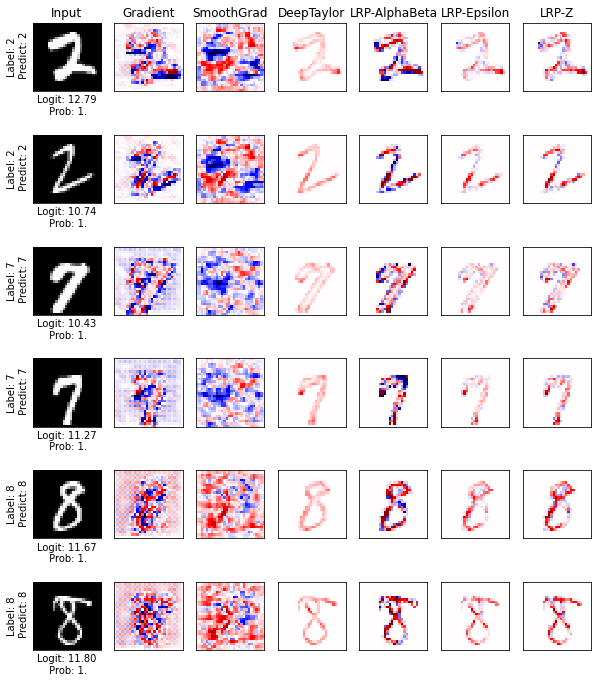

In [ ]:
ylabels = [[y_test[i], np.argmax(model.predict(x_test[i:i+1]))] for i in indices]    # classes' labels and model's predicts
titles = ['Input', 'Gradient', 'SmoothGrad', 'DeepTaylor', 'LRP-AlphaBeta', 'LRP-Epsilon', 'LRP-Z']    # Entrada e métodos
presm_probs = [[np.format_float_positional(np.max(model_wo_sm.predict(x_test[i:i+1])), 2), np.format_float_positional(np.max(model.predict(x_test[i:i+1])), 2)] for i in indices]


fig = plt.figure(figsize=(10, 12))

lin = 6    # 6 imagens de 3 classes distintas
col = 7    # 1 imagem de entrada + 6 métodos de análise
count = 0


for i in range(0, lin*col):

    fig.add_subplot(lin, col, i+1)
  
    if i % 7 == 0:
        plt.imshow(inputs_and_results[i], cmap='gray', interpolation='nearest')
        plt.ylabel(f'Label: {ylabels[int(i/7)][0]}\n Predict: {ylabels[int(i/7)][1]}')
        plt.xlabel(f'Logit: {presm_probs[int(i/7)][0]}\n Prob: {presm_probs[int(i/7)][1]}')
    else:
        plt.imshow(inputs_and_results[i], cmap='seismic', interpolation='nearest', clim=(-1, 1)) 
        # sns.heatmap(lista[i], cmap='seismic', xticklabels=False, yticklabels=False, square=True)
    
    if i < col:
        plt.title(titles[count])
        count+=1
        
    plt.xticks([])
    plt.yticks([])

- **Análises dos resultados:**

  - A figura acima apresenta os resultados após a aplicação dos métodos de explicação na rede neural treinada quando as imagens de dígitos da primeira coluna são inseridas na entrada da rede.

  - Nota-se que os métodos baseados em atribuição (*DeepTaylor*, LRP-AlphaBeta, LRP-Epsilon e LRPZ) apresentaram explicações melhores que os métodos baseados em função (*Gradient* e *SmoothGrad*).

  - Métodos baseados em função:
  
    - O *SmoothGrad* apresentou um desempenho pior, sendo muito difícil identificar nas explicações o conjunto de pixels em cada uma das imagens de entrada que foram mais importantes para suas corretas classificações.

    - Por outro lado, com o *Gradient* é possível identificar bem o conjunto de pixels das imagens de entrada que contribuíram para suas corretas classificações. Contudo, as explicações com esse método podem ser consideradas piores que a dos métodos baseados em atribuição pois muitos pixels em volta dos dígitos também se mostraram relativamente importantes para as decisões, como podem ser observadas nas classes 7 e 8.   

  - Métodos baseados em atribuição:

    - As explicações são mais simples e concisas.

    - O método *DeepTaylor* gerou boas explicações. Vale destacar que nas regiões mais grossas das imagens de dígitos, o método evidenciou apenas os pixels do contorno, como pode ser observado na primeira imagem de dígito 2 e na primeira imagem de dígito 7.    

    - Por fim, dentre as técnicas baseadas na propagação de relevância (LRP), os métodos LRP-Epsilon e LRPZ foram as mais eficientes pois apresentam um menor número de pixels de entrada com relevância negativa.
  
  - Logo, podemos concluir que os métodos de explicação mais eficientes no contexto de classificação de imagens de dígitos manuscritos são: *DeepTaylor*, LRP-Epsilon e LRPZ.

## **Questão 7-B: Análise das interpretações de uma RNA com a biblioteca *keras-vis***

- **Considerações iniciais:**

  - Nesta atividade é analisado as interpretações de uma rede neural treinada com a técnica *Activation Maximization*.
  
  - Nesta técnica, os pesos e as saídas da rede neural são mantidas constantes, de modo que a entrada da rede é modificada até que um determinado neurônio de interesse da camada de saída tenha ativação máxima.

  - Com a rede treinada no problema de classificação de dígitos manuscritos da base MNIST, é investigado com a biblioteca keras-vis as entradas que levam os neurônios da camada de saída a máxima ativação.

  - Essa técnica é muito dependente dos parâmetros *tv_weight* e *lp-norm*, que devem ser determinados para a obtenção de bons resultados.

  - O processo de determinação dos parâmetros foi feito conforme: 
    
    - https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb.
    
  - Os 2 parâmetros devem ser escolhidos de modo que suas contribuições nas perdas totais (*overall loss*) sejam reduzidas e ao mesmo tempo forneçam boas imagens de entrada.

  - Para cada um dos neurônios da camada de saída, o parâmetro *lp_norm* foi mantido nulo e duas buscas foram feitas para o parâmetro *tv_weight*:

    - Busca inicial: [0.001, 0.01, 0.1, 1, 10]
    - Busca refinada: de 0.1 a 1.5, com passo de 0.1

  - Valores obtidos para o parâmetro *tv_weight* para os neurônios referentes as classes 0 a 9 foram, respectivamente:
    
    - *tv_weight* = [1, 1, 1, 0.5, 0.5, 0.4, 0.4, 0.4, 0.5, 0.3]

  - Por fim, foi feito uma busca de 0.1 a 1 com passo de 0.1 para a escolha do parâmetro *lp_norm*. O valor encontrado foi:
  
    - *lp_norm* = 0.6.


- **Mudança da função de ativação softmax para linear na camada de saída:**

In [5]:
layer_idx = utils.find_layer_idx(model, model.layers[-1].name)

model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

- **Visualizações da ativação nas saídas da última camada densa:**

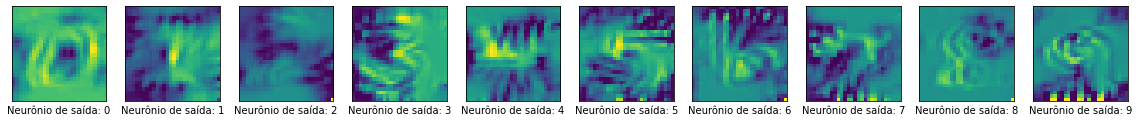

In [9]:
tv_weight_list = [1, 1, 1, 0.5, 0.5, 0.4, 0.4, 0.4, 0.5, 0.3]

fig = plt.figure(figsize=(20, 5))
ind = 0

for filter_idx in range(0, 10):

    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), max_iter=1000, verbose=False, lp_norm_weight=0.6, tv_weight=tv_weight_list[filter_idx])
    
    fig.add_subplot(1, 10, ind+1)
    plt.imshow(img.squeeze(), interpolation='nearest')
    plt.xlabel(f'Neurônio de saída: {filter_idx}')

    plt.xticks([])
    plt.yticks([])
    ind+=1

- **Análises dos resultados:**

  - A figura acima apresenta os padrões de entrada que levaram as máximas ativações dos neurônios da camada de saída.

  - Como pode ser observado, as imagens obtidas possuem distribuições nos valores dos pixels que se assemelham as imagens de dígitos manuscritos.

  - Os padrões obtidos para as classes 0, 3, 5, 6, 8 e 9 são de fácil identificação, enquanto para as classes 1, 2, 4 e 7 as imagens dos dígitos são menos reconhecíveis.